In [ ]:
# https://www.kaggle.com/datasets/rohitrox/healthcare-provider-fraud-detection-analysis

In [1]:
from pathlib import Path
import polars as pl
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.extend([str(Path.home() / 'PycharmProjects/core_graph')])

from core_graph.pipeline_nx import GraphPipelineNX, GraphPlotNX
from core_graph.pipeline_ig import GraphPipelineIG, GraphPlotIG
from core_graph.plot_interactive import GraphInteractive

In [2]:
path = Path('/media/kevin/data_4t/healthcare_fraud')

In [3]:
schema = ['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician','DeductibleAmtPaid']
inpatients = pl.read_csv(path / 'Train_Inpatientdata-1542865627584.csv', ignore_errors=True, columns=schema)
inpatients.head()

BeneID,ClaimID,Provider,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid
str,str,str,i64,str,str
"""BENE11001""","""CLM46614""","""PRV55912""",26000,"""PHY390922""","""1068"""
"""BENE11001""","""CLM66048""","""PRV55907""",5000,"""PHY318495""","""1068"""
"""BENE11001""","""CLM68358""","""PRV56046""",5000,"""PHY372395""","""1068"""
"""BENE11011""","""CLM38412""","""PRV52405""",5000,"""PHY369659""","""1068"""
"""BENE11014""","""CLM63689""","""PRV56614""",10000,"""PHY379376""","""1068"""


In [4]:
outpatients = pl.read_csv(path / 'Train_Outpatientdata-1542865627584.csv', columns=schema)
outpatients.head()

BeneID,ClaimID,Provider,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid
str,str,str,i64,str,i64
"""BENE11002""","""CLM624349""","""PRV56011""",30,"""PHY326117""",0
"""BENE11003""","""CLM189947""","""PRV57610""",80,"""PHY362868""",0
"""BENE11003""","""CLM438021""","""PRV57595""",10,"""PHY328821""",0
"""BENE11004""","""CLM121801""","""PRV56011""",40,"""PHY334319""",0
"""BENE11004""","""CLM150998""","""PRV56011""",200,"""PHY403831""",0


In [5]:
schema = [
    'BeneID', 'Gender', 'Race', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'IPAnnualReimbursementAmt', 
    'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt'
]
beneficiaries = pl.read_csv(path / 'Train_Beneficiarydata-1542865627584.csv', columns=schema)
beneficiaries.head()

BeneID,Gender,Race,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
str,i64,i64,i64,i64,i64,i64,i64,i64
"""BENE11001""",1,1,12,12,36000,3204,60,70
"""BENE11002""",2,1,12,12,0,0,30,50
"""BENE11003""",1,1,12,12,0,0,90,40
"""BENE11004""",1,1,12,12,0,0,1810,760
"""BENE11005""",1,1,12,12,0,0,1790,1200


In [6]:
labels = pl.read_csv(path / 'Train-1542865627584.csv')
labels.head()

Provider,PotentialFraud
str,str
"""PRV51001""","""No"""
"""PRV51003""","""Yes"""
"""PRV51004""","""No"""
"""PRV51005""","""Yes"""
"""PRV51007""","""No"""


In [7]:
df = (
    pl.concat([inpatients, outpatients], how='vertical_relaxed')
    .join(labels, on='Provider', how='left')
    .join(beneficiaries, on='BeneID', how='left')
    .with_columns(pl.col('PotentialFraud').replace_strict({'Yes': 1}, default=0, return_dtype=pl.Int8))
    .with_columns(
        (pl.col('Provider').str.strip_prefix('PRV').cast(pl.Int32) + 1_000_000).name.keep(),
        (pl.col('AttendingPhysician').str.strip_prefix('PHY').str.replace('NA', 0).cast(pl.Int32) + 2_000_000).name.keep()
    )
    .with_columns(pl.col('DeductibleAmtPaid').str.replace('NA', 0).cast(pl.Int32))
)
print(df.shape)
df.head()

BeneID,ClaimID,Provider,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,PotentialFraud,Gender,Race,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
str,str,i32,i64,i32,i32,i8,i64,i64,i64,i64,i64,i64,i64,i64
"""BENE11001""","""CLM46614""",1055912,26000,2390922,1068,1,1,1,12,12,36000,3204,60,70
"""BENE11001""","""CLM66048""",1055907,5000,2318495,1068,0,1,1,12,12,36000,3204,60,70
"""BENE11001""","""CLM68358""",1056046,5000,2372395,1068,0,1,1,12,12,36000,3204,60,70
"""BENE11011""","""CLM38412""",1052405,5000,2369659,1068,0,2,2,12,12,5000,1068,250,320
"""BENE11014""","""CLM63689""",1056614,10000,2379376,1068,0,2,1,12,12,21260,2136,120,100


In [8]:
# full
source = 'Provider'
target = 'AttendingPhysician'
G = nx.from_pandas_edgelist(df, source=source, target = target)

# sample
df_plotting = df.sample(n=1_000, seed=42)
H = nx.from_pandas_edgelist(df_plotting, source=source, target=target)

In [9]:
nodes_info_dict = {
    'eigenvector_centrality': nx.eigenvector_centrality_numpy,
    'pagerank': nx.pagerank
}

dict_ = dict(nx.degree(G))
nodes_info = pl.DataFrame({
    'Physician': list(dict_.keys()),
    'degree': list(dict_.values())
})
for i, f in nodes_info_dict.items():
    dict_ = dict(f(G))
    tmp = pl.DataFrame({
        'Physician': list(dict_.keys()),
        i: list(dict_.values())
    })
    nodes_info = nodes_info.join(tmp, on='Physician', how='left')
nodes_info = nodes_info.with_columns(pl.col('Physician').cast(pl.Int32))

df_enriched = (
    df
    .join(nodes_info, left_on='Provider', right_on='Physician', how='left')
    .rename({i: f'Provider_{i}' for i in nodes_info.columns[1:]})
    .join(nodes_info, left_on='AttendingPhysician', right_on='Physician', how='left')
    .rename({i: f'AttendingPhysician_{i}' for i in nodes_info.columns[1:]})
)
df_enriched.head()

BeneID,ClaimID,Provider,InscClaimAmtReimbursed,AttendingPhysician,DeductibleAmtPaid,PotentialFraud,Gender,Race,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Provider_degree,Provider_eigenvector_centrality,Provider_pagerank,AttendingPhysician_degree,AttendingPhysician_eigenvector_centrality,AttendingPhysician_pagerank
str,str,i32,i64,i32,i32,i8,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,f64
"""BENE11001""","""CLM46614""",1055912,26000,2390922,1068,1,1,1,12,12,36000,3204,60,70,69,0.024105,0.000371,1,0.000784,0.000006
"""BENE11001""","""CLM66048""",1055907,5000,2318495,1068,0,1,1,12,12,36000,3204,60,70,81,0.000027,0.000438,1,8.6875e-7,0.000006
"""BENE11001""","""CLM68358""",1056046,5000,2372395,1068,0,1,1,12,12,36000,3204,60,70,5,1.0766e-20,0.000033,1,1.9298e-19,0.000007
"""BENE11011""","""CLM38412""",1052405,5000,2369659,1068,0,2,2,12,12,5000,1068,250,320,17,2.6328e-7,0.000073,2,8.0371e-7,0.000009
"""BENE11014""","""CLM63689""",1056614,10000,2379376,1068,0,2,1,12,12,21260,2136,120,100,14,2.8407e-11,0.000077,1,9.2370e-13,0.000006


In [10]:
communities = GraphPipelineIG(G).find_communities()

In [12]:
G = GraphPipelineNX(G).find_communities()
I = G.subgraph(list(H.nodes()))

Building Infomap network from a NetworkX graph
Found 4352 modules with codelength 4.48282697 bits


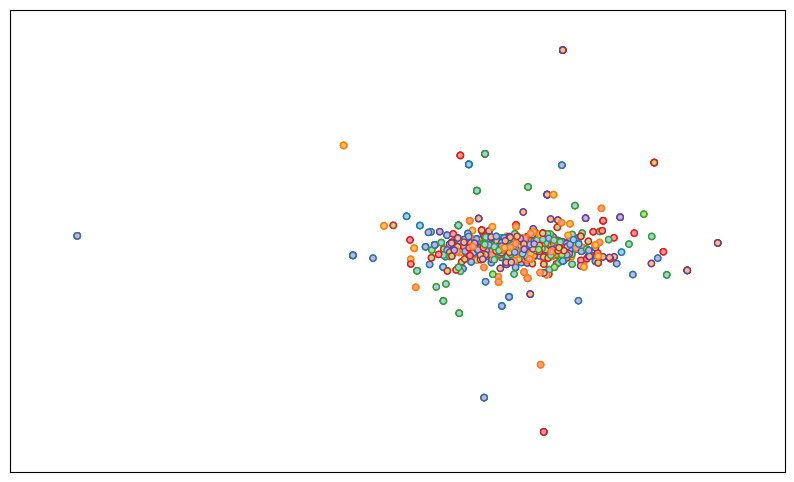

In [13]:
GraphPlotNX(I, community='community').draw_network()

In [14]:
tmp = pl.DataFrame(
    [(k, v) for k, v in nx.get_node_attributes(G, 'community').items()],
).transpose()
tmp.columns = ["AttendingPhysician", "AttendingPhysician_cluster"]
tmp = tmp.with_columns(pl.col('AttendingPhysician').cast(pl.Int32))
tmp.head()

df_enriched = df_enriched.join(tmp, on='AttendingPhysician', how='left')

In [15]:
# Splitting feature data from label data
col = [
    'InscClaimAmtReimbursed',
    'DeductibleAmtPaid',
    'Gender',
    'Race',
    'NoOfMonths_PartACov',
    'NoOfMonths_PartBCov',
    'IPAnnualReimbursementAmt',
    'IPAnnualDeductibleAmt',
    'OPAnnualReimbursementAmt',
    'OPAnnualDeductibleAmt',
    'Provider_degree',
    #  'Provider_closeness_centrality',
    'Provider_eigenvector_centrality',
    'Provider_pagerank',
    'AttendingPhysician_degree',
    #  'AttendingPhysician_closeness_centrality',
    'AttendingPhysician_eigenvector_centrality',
    'AttendingPhysician_pagerank',
    'AttendingPhysician_cluster'
]
X, y = df_enriched[col].to_pandas(), df_enriched['PotentialFraud']

print("Original shapes: ", "X:", X.shape, " y:", y.shape)

Original shapes:  X: (558211, 17)  y: (558211,)


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=69)
print(f"Shapes after splitting:\n\nX_train: {X_train.shape}, y_train: {y_train.shape}\
      \nX_test: {X_test.shape}, y_test: {y_test.shape}")

Shapes after splitting:

X_train: (334926, 17), y_train: (334926,)      
X_test: (223285, 17), y_test: (223285,)


In [17]:
baseline = [
    'InscClaimAmtReimbursed',
     'DeductibleAmtPaid',
     'Gender',
     'Race',
     'NoOfMonths_PartACov',
     'NoOfMonths_PartBCov',
     'IPAnnualReimbursementAmt',
     'IPAnnualDeductibleAmt',
     'OPAnnualReimbursementAmt',
     'OPAnnualDeductibleAmt'
]

graph_features = [
    'Provider_degree',
    #  'Provider_closeness_centrality',
    'Provider_eigenvector_centrality',
    'Provider_pagerank',
    'AttendingPhysician_degree',
    #  'AttendingPhysician_closeness_centrality',
    'AttendingPhysician_eigenvector_centrality',
    'AttendingPhysician_pagerank'
]

communities_features = [
    'AttendingPhysician_cluster'
]

feature_dict = {
    'baseline': baseline,
    'graph': baseline + graph_features,
    'community': baseline + graph_features + communities_features
}

In [18]:
pipeline_RFC = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=42))])
accuracy = {'name': [], 'accuracy': []}
for i, feature in feature_dict.items():
    X_train_subset = X_train[feature]
    X_test_subset = X_test[feature]

    pipeline_RFC.fit(X_train_subset, y_train)
    
    acc = round(pipeline_RFC.score(X_test_subset, y_test) * 100, 2)
    print(f"{i} Accuracy: {acc}")
    accuracy['name'].append(i)
    accuracy['accuracy'].append(acc)

baseline Accuracy: 62.9
graph Accuracy: 95.37
community Accuracy: 99.48


In [19]:
pl.DataFrame(accuracy).plot.bar(
    x='name', 
    y='accuracy'
)

:Bars   [name]   (accuracy)